# FRUIT INSPECTION
### THIRD TASK: FRUIT SEGMENTATION AND DEFECT DETECTION

Images in folder “final challenge” show 5 kiwis.
Students should segment the fruits and locate the defect in image “000007”. Special care should be taken to remove as
“background” the dirt on the conveyor as well as the sticker in image “000006”.

## Import and Image Management
In this section we import the necessaries libraries and retrive the images from google drive. Then we unzip the folder and start working

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import os

In [ ]:
! gdown --id 12vNN-PcvycfyN8TMREQStGl_9Rx_Ivm5

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12vNN-PcvycfyN8TMREQStGl_9Rx_Ivm5
To: /content/images.zip
100% 1.01M/1.01M [00:00<00:00, 103MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

Taken the folder, images are loaded in alphabetical order (sorted) and it is checked in the title if it is present:
* "C1" for color images, placed in color_images
* "C0" for black and white images, placed in gray_images

An image will have the same index in the gray or colored list (e.g. the corresponding grey image of color_images[0] will be in grey_images[0])

Then we print them out so we can show them and start working on them

In [ ]:
# assign directory
directory = '/content/images/task3/'
 
grey_images = []
color_images = []
# iterate over files in that directory, sorted
for filename in sorted(os.listdir(directory)):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    # if C1 then is colored image
    if "/content/images/task3/C1" in f:
      img = cv.imread(f)
      color_images.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    # if C0 then is gray image
    elif "/content/images/task3/C0" in f:
      img = cv.imread(f, cv.IMREAD_GRAYSCALE)
      grey_images.append(img)

Define the method plot_images to plot them in a handy way and the hconcat_resize to show the grey image

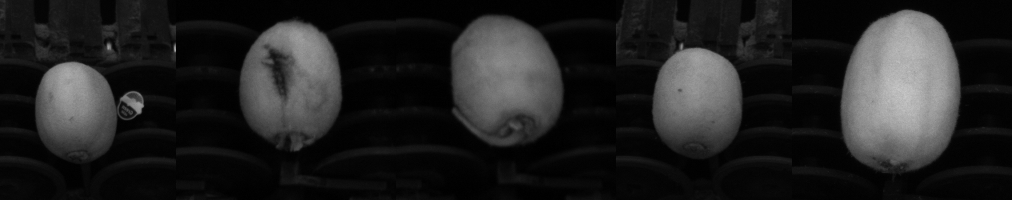

In [ ]:
# function to resize the images to show them with horizontal concatenation
def hconcat_resize(images, interpolation = cv.INTER_CUBIC):
  # take minimum hights
  h_min = min(img.shape[0] for img in images)
    
  # image resizing 
  images_resized = [cv.resize(img, (int(img.shape[1] * h_min / img.shape[0]),
                      h_min), interpolation = interpolation)
                    for img in images]
    
  # return final image
  return cv.hconcat(images_resized)
  
# show colored and grey images concatenated
# it should be cv.imshow, but in colab is disabled because it causes crashes.
cv2_imshow(hconcat_resize(grey_images))

In [ ]:
def plot_images(images, n_images, cmap=None, title='', suptitle='', custom_title=None, axis='off', size=None, figsize=(10, 5)):
  if not custom_title:
    custom_title = range(1, len(images)+1)

  fig, axes = plt.subplots(1, n_images, figsize=figsize)

  if suptitle:
    fig.suptitle(suptitle)

  for i in range(len(images)):
    axes[i].axis(axis)
    axes[i].set_title(title + " {}".format(custom_title[i]), size=size)
    axes[i].imshow(images[i], cmap=cmap)

  plt.show()

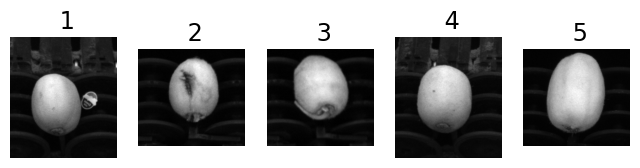

In [ ]:
plot_images(grey_images, len(grey_images), size="xx-large", cmap='gray', figsize=(8, 4))

We than show the histogram of the grey images

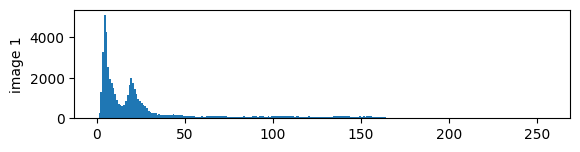

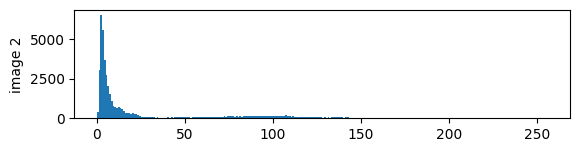

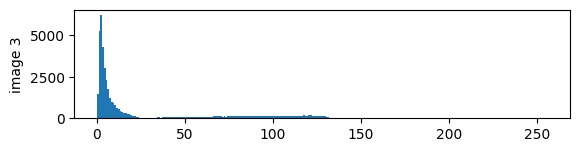

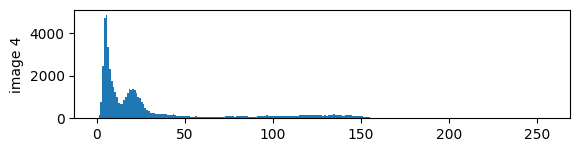

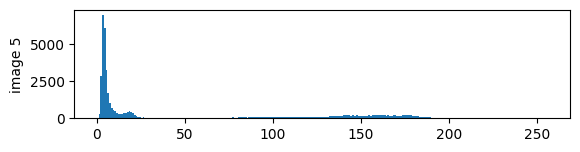

In [ ]:
for i in range(len(grey_images)):
  plt.subplot(int("311"))
  hist = cv.calcHist(grey_images[i], [0], None, [256], [0,256])
  plt.hist(grey_images[i].ravel(),256,[0,256])
  plt.ylabel('image ' + str(i+1))
  plt.show()

# Outline the fruit by generating a binary mask

We need to threshold the whole image in order to remove the background, but keeping intact the fruit.

First we apply a Gaussian Blur to uniform the background and then apply a threshold.

We have chosen to apply the **Otsu** thresholding and the binary thresholding to understand what approach could work better.

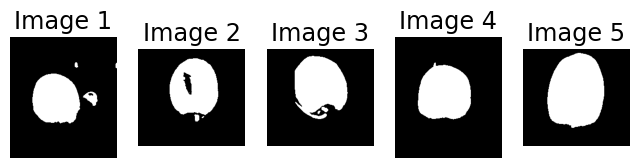

In [ ]:
binary_masks = []

for i in range(len(grey_images)):
  blur = cv.GaussianBlur(grey_images[i],(5,5),0)
  binary_masks.append(cv.threshold(blur, 0, 255, cv.THRESH_OTSU)[1])

plot_images(binary_masks, len(binary_masks), size="xx-large", cmap='gray', title="Image", figsize=(8, 4))

For the binary thresholding we have done some experiment and, as can be seen, the best threshold is around 70. With 50, the background and the sticker are too present, while with 90 and more, the fruit will not be whole.

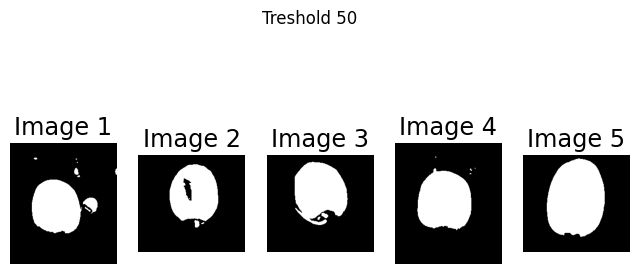

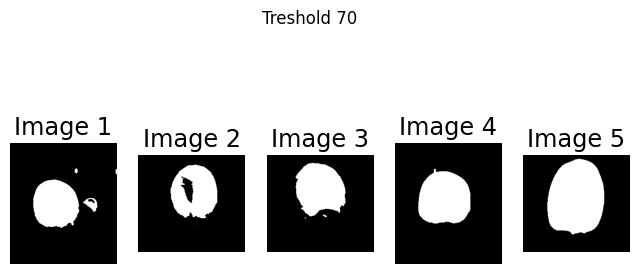

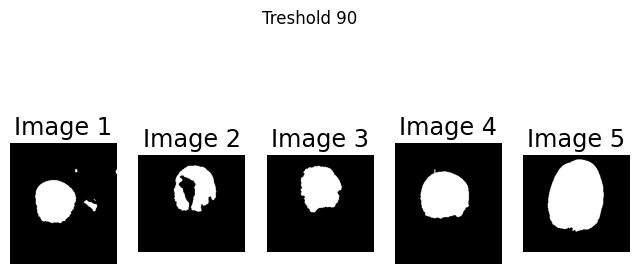

In [ ]:
tresholds = [50, 70, 90]
im_th_list = []

for i in range(len(tresholds)):
  binary_masks = []
  for j in range(len(grey_images)):
    blur = cv.GaussianBlur(grey_images[j],(5,5),0)
    if tresholds[i] == 70:
      im_th_list.append(cv.threshold(blur, tresholds[i], 1, cv.THRESH_BINARY)[1])
    binary_masks.append(cv.threshold(blur, tresholds[i], 1, cv.THRESH_BINARY)[1])
  plot_images(binary_masks, len(binary_masks), size="xx-large", suptitle='Treshold '+str(tresholds[i]), cmap='gray', title="Image", figsize=(8, 4))

Between Otsu and binary threshold, we have prefered the binary one because with Otsu the stiker is more solid so it would be more difficult to remove it.

Taking the list of binary_masks, we then apply the Opening operation that is composed by two Morphological Operations: Erosion followed by Dilation. The Opening one was taken because is an easy one to clean noise in the background and, in our case, even a little part of the foreground.

We have chosen a cross kernel because is the more precise one and a big dimension to remove completely the sticker. The Opening operation is followed by another dilation to mitigate the operation and let the foreground more compact.

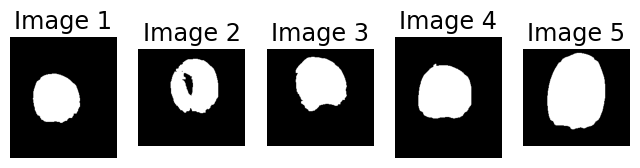

In [ ]:
im_opening_dilation = []
kernel_dilation = np.ones((3,3), np.uint8)
kernel_opening = cv.getStructuringElement(cv.MORPH_CROSS, (18,18))

for i in range(len(im_th_list)):  
  opening = cv.morphologyEx(im_th_list[i], cv.MORPH_OPEN, kernel_opening)
  dilation = cv.dilate(opening, kernel_dilation)
  im_opening_dilation.append(dilation)

plot_images(im_opening_dilation, len(im_opening_dilation), size="xx-large", cmap='gray', title="Image", figsize=(8, 4))

Then for convenience we choose to color the background and the defect with grey to be easy to manipulate after.

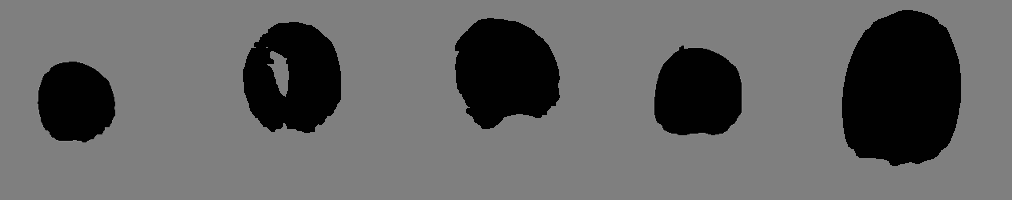

In [ ]:
# color of the black pixels in order to differentiate the imperfections from the background
for i in range(len(im_opening_dilation)):
  im_opening_dilation[i][im_opening_dilation[i] == 0] = 127

# show threshold image
cv2_imshow(hconcat_resize(im_opening_dilation))

Lastly, we have applied a floodfilling operation to let only the defect remain and, taking the original colored images, we set the color of the defect with a bright one to be more visible

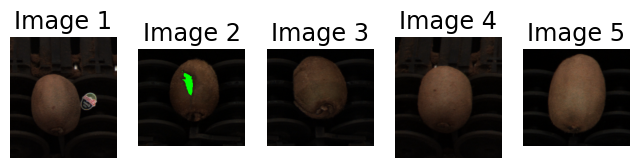

In [ ]:
detected_imperfections = []
final_images = []
for img in color_images:
  final_images.append(img)

for i, area in enumerate(im_opening_dilation):
  m, n, _ = final_images[i].shape
  cv.floodFill(area, None, (0,0),1)
  for j in range(m):
    for k in range(n):
      if area[j,k] == 127:
        final_images[i][j,k,0] = 0
        final_images[i][j,k,1] = 255
        final_images[i][j,k,2] = 0
  detected_imperfections.append(final_images[i])

plot_images(detected_imperfections, len(detected_imperfections), size="xx-large", title="Image", figsize=(8, 4))

# Made by:
  - Luca Reggiani
  - Simone Vizzuso